<a href="https://colab.research.google.com/github/dgdeleonardis/colabs/blob/main/recap_risultati.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Recap fase di testing**

## Introduzione
All'interno di ```gym-malware``` nella sua versione originale sono presenti due **environment**: **```malware-v0```** e **```malware-score-v0```**.
La differenza tra questi è nella **policy di reward**:
- **`malware-v0`**: \\
  → ```win reward```: ```10```; \\
  → ```lose reward```: ```0```; \\
  → ```intermediate reward```: ```0```; \\
- **```malware-score-v0```**: \\
  → `win reward`: ``10``; \\
  → ```lose reward```: ```0```; \\
  → `intermediate reward`: `original_score - score`, dove: \\
    - `original_score` ≜ *`score_function(bytes_original_malware)`* ⟺ ... ⟺ *`local_model.predict_proba(features)`*
    - `score` ≜ *`score_function(bytes_current_malware)`* ⟺ ...⟺ *`local_model.predict_proba(features)`* \\
È in sostanza la **differenza** tra la **probabilità iniziale** e quella all'**operazione i-esima** che il sample sia etichettato come malware dal modello.

È noto che l'environment **`malware-score-v0`**, il quale non è propriamente *full black-blox, ha delle prestazioni nettamente migliori rispetto al *full black-box* *`malware-v0`*. \\
L'obiettivo è quello di definire un environment che non utilizzi nessuna informazione data dal classificatore, ma che allo stesso tempo abbia delle prestazioni equiparabili al **`malware-score-v0`**.

## Metodologia del testing
Per la fase di testing è stato definito uno script che implementa una **"false" K-fold cross validation**. \\
Nello specifico: *dato un environment specificato dall'utente viene partizionato il dataset in **K partizioni** (la scelta dei samples non è sequenziale, ma bensì casuale) e **ciclicamente** vengono effettuate delle fasi di **training + test** utilizzando K-1 partizioni come training set e la restante partizione come test set.*

In [ ]:
# imports
import pickle
from datetime import datetime, date
import sys
import csv
import os
import numpy as np
import random

from gym.envs.registration import register

from test_agent_kerasrl import evaluate, model_policy
from train_agent_kerasrl import train_dqn_model
from gym_malware import MAXTURNS
from gym_malware import sha256  as dataset, sha256_holdout # dataset


# inizializzazione e scelta dell'environment
K = 5
rounds = int((len(dataset)/K)*(K-1)*10)
testDate = date.today()

env_name = sys.argv[1]
if env_name == 'malware_env':
    setup_dict = { "id": "malware{}-v0",
        "id_test": "malware{}-test-v0",
        "entry_point": "gym_malware.envs:MalwareEnv",
        "model_filename": "dqn_{}.h5"
    }
elif env_name == 'malware_score_env':
    setup_dict = { "id": "malware{}-score-v0",
        "id_test": "malware{}-score-test-v0",
        "entry_point": "gym_malware.envs:MalwareScoreEnv",
        "model_filename": "dqn_score_{}.h5"
    }
elif env_name == 'malware_table_env':
    setup_dict = { "id": "malware{}-table-v0",
        "id_test": "malware{}-table-test-v0",
        "entry_point": "gym_malware.envs:MalwareTableEnv",
        "model_filename": "dqn_table__{}.h5"
    }
elif env_name == 'malware_table_scaled_env':
    setup_dict = { "id": "malware{}-table-scaled-v0",
        "id_test": "malware{}-table-scaled-test-v0",
        "entry_point": "gym_malware.envs:MalwareTableScaledEnv",
        "model_filename": "dqn_table_scaled_{}.h5"
    }
elif env_name == 'malware_table_softmax_env':
    setup_dict = { "id": "malware{}-table-softmax-v0",
        "id_test": "malware{}-table-softmax-test-v0",
        "entry_point": "gym_malware.envs:MalwareTableSoftmaxEnv",
        "model_filename": "dqn_table_softmax_{}.h5"
    }
else:
    print("Env not defined!")
    exit()

def open_logfile(logfile_path="k-fold_crossvalidation-kerasrl-{}-{}.cvs".format(setup_dict["id"].format(""), testDate)):
	exist = os.path.exists(logfile_path)
	logfile = open(logfile_path, "a")
	writer = csv.writer(logfile)
	if not exist:
		header = [ "model_filename",  "env_name", "training_rounds", "test_episodes", "success", "misclassified"]
		writer.writerow(header)
	return logfile, writer


if __name__ == "__main__":
    
    # creo K partizioni partendo dal dataset
    aux_list = dataset.copy()
    folds = [[] for _ in range(0, K)]
    i = 0
    while len(aux_list) != 0:
      # scelgo casualmente un elemento del dataset e lo aggiungo al fold i-esimo
      entry = random.choice(aux_list)  
      folds[i].append(entry)
      aux_list.remove(entry)
      i = (i + 1) % K

    # eseguo per K volte addestramento + test utilizzando ad ogni ciclo una diversa
    # partizione per il test e utilizzando le rimanenti K-1 per il training
    arr = [*range(0, K)]
    while len(arr) != 0:
        test_index = random.choice(arr)
        training_indexes = [x for x in range(0, K) if x != test_index]
        arr.remove(test_index)
        test_set = folds[test_index]
        # creo il training set
        training_set = []
        for i in training_indexes:
            training_set.extend(folds[i])
        
        register(
            id=setup_dict["id"].format(test_index),
            entry_point=setup_dict["entry_point"],
            kwargs={'random_sample': True, 'maxturns': MAXTURNS, 'sha256list': training_set}
        )
        # fase di training con numero di round pari a MAXTURNS*len(training_set)
        print("---------- START TRAINING ----------\n")
        print("ROUNDS:", rounds)
        agent, model, history_train, history_test = train_dqn_model([1024, 256], rounds=rounds, run_test=False, env_name=setup_dict["id"].format(test_index))
        print("---------- END TRAINING ----------")
        
        date = datetime.now().strftime("%d%m%Y-%H:%M:%S")
        model_filename = setup_dict["model_filename"].format(date)
        model.save('models/{}'.format(model_filename), overwrite=True)
        
        with open('histories/history_malware_env-test_ {}.pickle'.format(date), 'wb') as f:
            pickle.dump(history_test, f, pickle.HIGHEST_PROTOCOL)

        register(
            id=setup_dict["id_test"].format(test_index),
            entry_point=setup_dict["entry_point"],
            kwargs={'random_sample': False, 'maxturns': MAXTURNS, 'sha256_holdout': test_set}
        )
        # fase di test 
        print("---------- START TEST ----------")
        success, misclassified = evaluate(model_policy(model), model_filename, test_set)
        print("---------- END TEST ----------")
        total = len(sha256_holdout) - len(misclassified) # don't count misclassified towards success

        # output 
        print("Success rate (black-box): {}\n".format( len(success) / total ))
        print("Misclassified (black-box): {}".format(len(misclassified)))
        logfile, csv_writer = open_logfile()
        data = [ model_filename,
		      setup_dict["id"].format(''),
		      rounds,
		      len(test_set),
		      len(success),
          len(misclassified)
	      ]
        csv_writer.writerow(data)
        logfile.close()

Seguendo le indicazioni del paper di *Anderson et al.* da cui è tratto `gym-malware`, l'**accuracy** dell'agente è ottenuta andando ad eliminare dal totale i sample classificati erroneamente come benigni dal modello: $\frac{\texttt{succes}}{\texttt{total}-\texttt{misclassified}}$ \\
Ogni test è stato effettuato con un **K** pari a **5** avendo quindi un numero di **round** pari all'incirca a **12k** *(1200 circa sample)* per il **training** e un numero di sample per la **fase di test** pari a **309/310**. \\
Con la funzione `evaluate(...)` così definita:

In [ ]:
def evaluate( action_function, model_name):
    success=[]
    misclassified = []
    count = 0
    for sha256 in sha256_holdout:
        count = count + 1
        print("sample:", count, "/", len(sha256_holdout), "of {}\n".format(model_name))
        success_dict = defaultdict(list)
        bytez = interface.fetch_file(sha256)
        label = interface.get_label_local(bytez)
        if label == 0.0:
            misclassified.append(sha256)
            continue # already misclassified, move along
        for _ in range(MAXTURNS):
            action = action_function( bytez )
            print(action)
            success_dict[sha256].append(action)
            bytez = manipulate.modify_without_breaking( bytez, [action] )
            new_label = interface.get_label_local( bytez )   # test against local classifier
            if new_label == 0.0:
                success.append(success_dict)
                break
    return success, misclassified # evasion accuracy is len(success) / len(sha256_holdout)

## Script per la lettura e visualizzazione dei dati

In [5]:
import csv
import numpy as np
import matplotlib.pyplot as plt

In [6]:
def get_results(filename):
  logfile = open(filename, 'r')
  reader = csv.reader(logfile)
  data = []
  next(reader) # escludo la riga di intestazione
  for row in reader:
    data.append({
        "model": row[0],
        "env": row[1],
        "rounds": int(row[2]),
        "test_samples": int(row[3]),
        "success": int(row[4]),
        "misclassified": int(row[5])
    })
  return data

In [7]:
def get_accuracy(test_data):
  accuracy = list()
  for x in test_data:
    accuracy.append(x['success']/(x['test_samples']-x['misclassified']))
  return accuracy

In [8]:
def plot_bar_acc(arr_accuracy):
  plt.bar([str(_) for _ in range(1, len(arr_accuracy)+1)],arr_accuracy)
  plt.axhline(y = np.average(arr_accuracy), color = 'r', linestyle = 'dashed')
  plt.show()

## **`malware-v0`**

### *Codice*

In [ ]:
label_function = interface.get_label_local


class MalwareEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, sha256list, random_sample=True, maxturns=3, output_path='evaded/blackbox/', cache=False):
        self.cache = cache
        self.available_sha256 = sha256list
        self.action_space = spaces.Discrete(len(ACTION_LOOKUP))
        self.maxturns = maxturns
        self.feature_extractor = pefeatures.PEFeatureExtractor()
        self.random_sample = random_sample
        self.sample_iteration_index = 0
        self.output_path = os.path.join(
            os.path.dirname(
                os.path.dirname(
                    os.path.dirname(
                        os.path.abspath(__file__)))), output_path)
        if not os.path.exists(output_path):
            os.makedirs(output_path)

        self.history = OrderedDict()

        self.samples = {}
        if self.cache:
            for sha256 in self.available_sha256:
                try:
                    self.samples[sha256] = interface.fetch_file(self.sha256)
                except interface.FileRetrievalFailure:
                    print("failed fetching file")
                    continue  # try a new sha256...this one can't be retrieved from storage

        self._reset()

    def _step(self, action_index):
        self.turns += 1
        self._take_action(action_index) # update self.bytez

        # get reward
        try:
            self.label = label_function(self.bytez)
        except interface.ClassificationFailure:
            print("Failed to classify file")
            episode_over = True
        else:
            self.observation_space = self.feature_extractor.extract(self.bytez)
            if self.label == 0:
                # we win!
                reward = 10.0 # !! a strong reward
                episode_over = True
                self.history[self.sha256]['evaded'] = True

                # store sample to output directory
                m = hashlib.sha256()
                m.update( self.bytez )
                sha256 = m.hexdigest()
                self.history[self.sha256]['evaded_sha256'] = sha256
                
                with open( os.path.join( self.output_path, sha256), 'wb') as outfile:
                    outfile.write( self.bytez )
            elif self.turns >= self.maxturns:
                # out of turns :(
                reward = 0.0
                episode_over = True
            else:
                reward = 0.0
                episode_over = False

        if episode_over:
            print("episode is over: reward = {}!".format(reward))

        return self.observation_space, reward, episode_over, {}

    def _take_action(self, action_index):
        assert action_index < len(ACTION_LOOKUP)
        action = ACTION_LOOKUP[action_index]
        print(action)
        self.history[self.sha256]['actions'].append(action)
        self.bytez = bytes( manipulate.modify_without_breaking(self.bytez, [action]))

    def _reset(self):
        self.turns = 0
        while True:
            # get the new environment
            if self.random_sample:
                self.sha256 = random.choice(self.available_sha256)
            else: # draw a sample at random
                self.sha256 = self.available_sha256[ self.sample_iteration_index % len(self.available_sha256) ]
                self.sample_iteration_index += 1

            self.history[self.sha256] = {'actions': [], 'evaded': False}
            if self.cache:
                self.bytez = self.samples[self.sha256]
            else:
                try:
                    self.bytez = interface.fetch_file(self.sha256)
                except interface.FileRetrievalFailure:
                    print("failed fetching file")
                    continue  # try a new sha256...this one can't be retrieved from storage

            original_label = label_function(self.bytez)            
            if original_label == 0:
                # skip this one, it's already benign, and the agent will learn nothing
                continue

            print("new sha256: {}".format(self.sha256))                

            self.observation_space = self.feature_extractor.extract(self.bytez)

            break  # we're done here

        return np.asarray(self.observation_space)

    def _render(self, mode='human', close=False):
        pass

### *Risultati*

In [9]:
filename = "/content/drive/MyDrive/k-fold_crossvalidation-kerasrl-malware-v0-2022-12-02.cvs"

In [10]:
data = get_results(filename)
arr_accuracy = np.array(get_accuracy(data))
avg_accuracy = np.average(arr_accuracy)

In [11]:
print("Accuracy:")
for i in range(0, len(arr_accuracy)):
  print("-> n.{}: {}% ({})".format(i, np.round(arr_accuracy[i]*100, decimals=2), arr_accuracy[i]))
print("Average accuracy: {}% ({})".format(np.round(avg_accuracy*100, decimals=2), avg_accuracy))

Accuracy:
-> n.0: 39.63% (0.39634146341463417)
-> n.1: 42.48% (0.42483660130718953)
-> n.2: 3.33% (0.03333333333333333)
-> n.3: 35.06% (0.35064935064935066)
-> n.4: 30.71% (0.30714285714285716)
Average accuracy: 30.25% (0.3024607211694729)


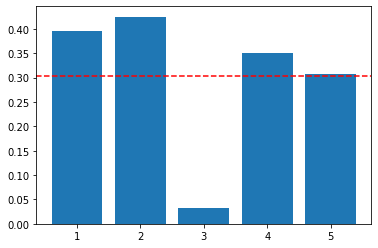

In [12]:
plot_bar_acc(arr_accuracy)

## **`malware-score-v0`**

### *Risultati*

In [13]:
filename = "/content/drive/MyDrive/k-fold_crossvalidation-kerasrl-malware-score-v0-2022-12-13.cvs"

In [14]:
data = get_results(filename)
arr_accuracy = np.array(get_accuracy(data))
avg_score_accuracy = np.average(arr_accuracy)

In [15]:
print("Accuracy:")
for i in range(0, len(arr_accuracy)):
  print("-> n.{}: {}% ({})".format(i, np.round(arr_accuracy[i]*100, decimals=2), arr_accuracy[i]))
print("Average accuracy: {}% ({})".format(np.round(avg_score_accuracy*100, decimals=2), avg_score_accuracy))

Accuracy:
-> n.0: 34.15% (0.34146341463414637)
-> n.1: 32.0% (0.32)
-> n.2: 16.44% (0.1643835616438356)
-> n.3: 8.7% (0.08695652173913043)
-> n.4: 43.57% (0.4357142857142857)
Average accuracy: 26.97% (0.26970355674627966)


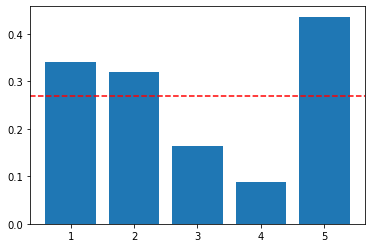

In [16]:
plot_bar_acc(arr_accuracy)

## **`malware-table-v0`**
**`malware-table-v0`** è il primo esperimento per la definizione di un environment che migliori le prestazioni del basilare **`malware-v0`**. \\
L'idea alla base è quello di impiegare una **policy di reward** *naif* che vada a premiare le action che statisticamente sono maggiormente presenti nei casi vincenti. \\
Pertanto nella fase di training è definita un dizionario in cui ad ogni *action* è asseganto il seguente valore: \\
   `name_action` → $\frac{\texttt{num_winning_episodes_with_name_action}}{\texttt{num_winning_episodes}}$ \\
   E pertanto la funzione di assegnazione dei reward sarà: \\
    → ```win reward```: ```10```; \\
    → ```lose reward```: ```0```; \\
    → ```intermediate reward```: ```actions_table[action]```; \\
   

### *Codice*

In [ ]:
label_function = interface.get_label_local


class MalwareTableEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, sha256list, random_sample=False, maxturns=3, output_path='evaded/table/', cache=False):
        self.cache = cache
        self.available_sha256 = sha256list
        self.action_space = spaces.Discrete(len(ACTION_LOOKUP))
        self.maxturns = maxturns
        self.feature_extractor = pefeatures.PEFeatureExtractor()
        self.random_sample = random_sample
        self.sample_iteration_index = 0

        self.count_turns = 0
        self.count_episodes = -1
        self.count_won_episodes = 0
        print("LEN SHA256:", len(sha256list))
        # create actions table
        self.actions_table = dict.fromkeys(manipulate.ACTION_TABLE.keys(), 0.0)
        self.actions_table_normalized = dict.fromkeys(manipulate.ACTION_TABLE.keys(), 0.0)
        self.output_path = os.path.join(
            os.path.dirname(
                os.path.dirname(
                    os.path.dirname(
                        os.path.abspath(__file__)))), output_path)
        if not os.path.exists(output_path):
            os.makedirs(output_path)

        self.history = OrderedDict()

        self.samples = {}
        if self.cache:
            for sha256 in self.available_sha256:
                try:
                    self.samples[sha256] = interface.fetch_file(self.sha256)
                except interface.FileRetrievalFailure:
                    print("failed fetching file")
                    continue  # try a new sha256...this one can't be retrieved from storage

        self._reset()

    def unique(actions):
        return list(set(actions))

    def _table_update(self, reward, turns, actions):
        # print("reward:", reward, "\t| value:", value) # DEBUG INSTRUCTION
        if reward == 10:
            value = 1
        else:
            value = 0
        print(actions)
        print(type(actions))
        for action in list(set(actions)):
            self.actions_table[action] += value
        
        self.actions_table_normalized = self.actions_table.copy()
        for key in self.actions_table_normalized:
            self.actions_table_normalized[key] = self.actions_table_normalized[key] / self.count_won_episodes
        print("table:", self.actions_table) # DEBUG INSTRUCTION
        print("table normalized:", self.actions_table_normalized) # DEBUG INSTRUCTION
        print("EPISODES:", self.count_episodes) # DEBUG INSTRUCTION



    def _step(self, action_index):
        self.turns += 1
        self._take_action(action_index) # update self.bytez
        self.count_turns += 1
        print("EPISODE: {}; STEP N.{}; TOTAL STEP: {}". format(self.count_episodes, self.turns, self.count_turns))
        # get reward
        try:
            self.label = label_function(self.bytez)
        except interface.ClassificationFailure:
            print("Failed to classify file")
            episode_over = True
        else:
            self.observation_space = self.feature_extractor.extract(self.bytez)
            if self.label == 0:
                # we win!
                reward = 10.0 # !! a strong reward
                self.count_won_episodes += 1
                # aggiornamento della tabella delle potenzialita' delle azioni nel caso di vittoria
                self._table_update(reward, self.turns, self.history[self.sha256]['actions'])

                episode_over = True
                self.history[self.sha256]['evaded'] = True

                # store sample to output directory
                m = hashlib.sha256()
                m.update( self.bytez )
                sha256 = m.hexdigest()
                self.history[self.sha256]['evaded_sha256'] = sha256
                
                with open( os.path.join( self.output_path, sha256), 'wb') as outfile:
                    outfile.write( self.bytez )
            elif self.turns >= self.maxturns:
                # out of turns :(
                reward = 0

                # aggiornamento della tabella delle potenzialita' delle azioni nel caso di sconfitta
                #self._table_update(reward, self.turns, self.history[self.sha256]['actions'])
                episode_over = True

            else:
                # utilizzo della tabella delle potenzialita' per determinare un reward intermedio
                print(ACTION_LOOKUP[action_index])
                reward = self.actions_table_normalized[ACTION_LOOKUP[action_index]]
                print("intermediate reward:", reward)
                episode_over = False

        if episode_over:
            print("episode is over: reward = {}!".format(reward))
            # diego: si scrive su file al termine dell'episodio lo storico del sample
            with open("history-malware_table_env.txt", 'a') as histories_file:
              histories_file.write(str(self.history[self.sha256]) + "\n")

        return self.observation_space, reward, episode_over, {}

    def _take_action(self, action_index):
        assert action_index < len(ACTION_LOOKUP)
        action = ACTION_LOOKUP[action_index]
        print(action)
        self.history[self.sha256]['actions'].append(action)
        self.bytez = bytes( manipulate.modify_without_breaking(self.bytez, [action]))

    def _reset(self):
        self.turns = 0
        self.count_episodes += 1
        print("NUMERO DI EPISODI:", self.count_episodes)
        while True:
            # get the new environment
            if self.random_sample:
                self.sha256 = random.choice(self.available_sha256)
            else: # draw a sample at random
                self.sha256 = self.available_sha256[ self.sample_iteration_index % len(self.available_sha256) ]
                self.sample_iteration_index += 1

            self.history[self.sha256] = {'actions': [], 'evaded': False}
            if self.cache:
                self.bytez = self.samples[self.sha256]
            else:
                try:
                    self.bytez = interface.fetch_file(self.sha256)
                except interface.FileRetrievalFailure:
                    print("failed fetching file")
                    continue  # try a new sha256...this one can't be retrieved from storage

            original_label = label_function(self.bytez)            
            if original_label == 0:
                # skip this one, it's already benign, and the agent will learn nothing
                continue

            print("new sha256: {}".format(self.sha256))                

            self.observation_space = self.feature_extractor.extract(self.bytez)

            break  # we're done here

        return np.asarray(self.observation_space)

    def _render(self, mode='human', close=False):
        pass

### *Risultati*

In [17]:
filename = "/content/drive/MyDrive/k-fold_crossvalidation-kerasrl-malware-table-v0-2022-12-06.cvs"

In [18]:
data = get_results(filename)
arr_accuracy = np.array(get_accuracy(data))
avg_table_accuracy = np.average(arr_accuracy)

In [19]:
print("Accuracy:")
for i in range(0, len(arr_accuracy)):
  print("-> n.{}: {}% ({})".format(i, np.round(arr_accuracy[i]*100, decimals=2), arr_accuracy[i]))
print("Average accuracy: {}% ({})".format(np.round(avg_table_accuracy*100, decimals=2), avg_table_accuracy))

Accuracy:
-> n.0: 25.34% (0.2534246575342466)
-> n.1: 0.0% (0.0)
-> n.2: 25.16% (0.25161290322580643)
-> n.3: 31.9% (0.31901840490797545)
-> n.4: 14.86% (0.14864864864864866)
Average accuracy: 19.45% (0.1945409228633354)


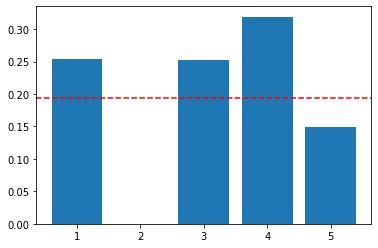

In [20]:
plot_bar_acc(arr_accuracy)

## **`malware-table-scaled-v0`**
A differenza della versione `table` questo environment scala il reward intermedio di un fattore $α=0,1$, limitando così l'effetto della `actions_table`.
Pertanto: \\
    → ```win reward```: ```10```; \\
    → ```lose reward```: ```0```; \\
    → ```intermediate reward```: ```alpha * actions_table[action]```; \\

### *Risultati*

In [21]:
filename = "/content/drive/MyDrive/k-fold_crossvalidation-kerasrl-malware-table-scaled-v0-2022-12-09.cvs"

In [22]:
data = get_results(filename)
arr_accuracy = np.array(get_accuracy(data))
avg_table_scaled_accuracy = np.average(arr_accuracy)

In [23]:
print("Accuracy:")
for i in range(0, len(arr_accuracy)):
  print("-> n.{}: {}% ({})".format(i, np.round(arr_accuracy[i]*100, decimals=2), arr_accuracy[i]))
print("Average accuracy: {}% ({})".format(np.round(avg_table_scaled_accuracy*100, decimals=2), avg_table_scaled_accuracy))

Accuracy:
-> n.0: 43.79% (0.43790849673202614)
-> n.1: 34.9% (0.348993288590604)
-> n.2: 39.38% (0.39375)
-> n.3: 0.0% (0.0)
-> n.4: 27.52% (0.2751677852348993)
Average accuracy: 29.12% (0.2911639141115059)


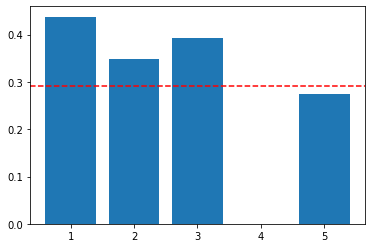

In [24]:
plot_bar_acc(arr_accuracy)

## **`malware-table-softmax-v0`**
In questo environment anziché effettuare il rapporto tra gli episodi vincenti in cui è presente l'*action* in questione e il totale degli episodi vincenti, si è utilizzata la **funzione softmax**, distribuendo i valori associati alle singole azioni in un intervallo da $[0,1)$ *accentuando le azioni più statisticamente vincenti*

### *Risultati*

In [25]:
filename = "/content/drive/MyDrive/k-fold_crossvalidation-kerasrl-malware-table-softmax-v0-2022-12-09.cvs"

In [26]:
data = get_results(filename)
arr_accuracy = np.array(get_accuracy(data))
avg_table_softmax_accuracy = np.average(arr_accuracy)

In [27]:
print("Accuracy:")
for i in range(0, len(arr_accuracy)):
  print("-> n.{}: {}% ({})".format(i, np.round(arr_accuracy[i]*100, decimals=2), arr_accuracy[i]))
print("Average accuracy: {}% ({})".format(np.round(avg_table_softmax_accuracy*100, decimals=2), avg_table_softmax_accuracy))

Accuracy:
-> n.0: 34.87% (0.34868421052631576)
-> n.1: 22.3% (0.22297297297297297)
-> n.2: 1.32% (0.013157894736842105)
-> n.3: 37.58% (0.37575757575757573)
-> n.4: 39.22% (0.39215686274509803)
-> n.5: 28.86% (0.28859060402684567)
Average accuracy: 27.36% (0.27355335346094173)


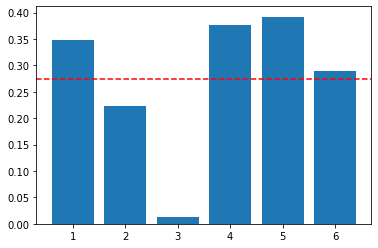

In [28]:
plot_bar_acc(arr_accuracy)

## Conclusione

In [30]:
print("MALWARE ENV ACCURACY: {}% ({})".format(np.round(avg_accuracy*100, decimals=2), avg_accuracy))
print("MALWARE SCORE ENV ACCURACY: {}% ({})".format(np.round(avg_score_accuracy*100, decimals=2), avg_score_accuracy))
print("MALWARE TABLE ENV ACCURACY: {}% ({})".format(np.round(avg_table_accuracy*100, decimals=2), avg_table_accuracy))
print("MALWARE TABLE SCALED ENV ACCURACY: {}% ({})".format(np.round(avg_table_scaled_accuracy*100, decimals=2), avg_table_scaled_accuracy))
print("MALWARE TABLE SOFTMAX ENV ACCURACY: {}% ({})".format(np.round(avg_table_softmax_accuracy*100, decimals=2), avg_table_softmax_accuracy))

MALWARE ENV ACCURACY: 30.25% (0.3024607211694729)
MALWARE SCORE ENV ACCURACY: 26.97% (0.26970355674627966)
MALWARE TABLE ENV ACCURACY: 19.45% (0.1945409228633354)
MALWARE TABLE SCALED ENV ACCURACY: 29.12% (0.2911639141115059)
MALWARE TABLE SOFTMAX ENV ACCURACY: 27.36% (0.27355335346094173)
